In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Homework 3


#### Hasan Cetin

<hr />

## The Problem

Assume that the utility function is the one that we have used in the HW 2: $u(c_t, h_t) = ln(c_t) + \psi ln(1-h_t)$. Let's write down the maximization problem of the economy with distortions:

$$\max_{c_t, h_t} \mathbb{E}_0 \sum_{t = 0}^{\infty} \hat \beta^t [ln(c_t) + \psi ln(1-h_t)] $$
$$\text{s.t. } c_t  =  \frac{1}{1 + \tau_{ct}} [r_t k_t + w_t h_t + T_t - \tau_{ht} w_th_t - \tau_{pt}(r_tk_t - \delta k_t) - x_t -\tau_{dt}(r_tk_t - x_t - \tau_{pt}(r_tk_t - \delta k_t))]$$
$$x_t = (1+ \gamma_n)k_{t+1} - (1-\delta)k_t$$
$$ 0 \leq h_t \leq 1$$
$$\hat \beta^t = ((1+\gamma_n)\beta)^t$$
$$S_t = PS_{t-1} + Q \epsilon_{t}$$
$$c_t,x_t \geq 0$$

where: $S_t = \begin{bmatrix}ln(z_t) \\ \tau_{ct} \\ \tau_{ht} \\ \tau_{dt} \\ \tau_{pt} \\ ln(g_t) \end{bmatrix}$ is the vector of exogenous state variables.

Note that in this model, the state and control vectors will be the following:

- State vector: $X_t := \begin{bmatrix} 1 \\ k_t  \\ ln(z_t) \\ \tau_{ct} \\ \tau_{ht} \\ \tau_{dt} \\ \tau_{pt} \\ ln(g_t)  \\ K_t \\ H_t \\ T_t \end{bmatrix}_{11x1}$

- Control vector: $u_t := \begin{bmatrix} k_{t+1} \\ h_t \end{bmatrix}_{2x1}$ where:
    
    - $k_t$: Per capita individual capital stock 
    - $h_t$: Per capita individual hours worked
    - $z_t$: Efficiency shock/wedge
    - $\tau_{ct}$: Consumption tax/wedge
    - $\tau_{ht}$: Labor income tax/wedge
    - $\tau_{pt}$: Profit tax/wedge
    - $\tau_{dt}$: Dividend tax/wedge
    - $g_t$: Per capita government consumption/wedge
    - $K_t$: Aggregate capital stock
    - $H_t$: Aggregate hours worked
    - $T_t$: Transfer payments (Lump-sum)

#### Our Strategy

We'll do more or less the same analysis that we did in Homework 2. (And in Homework 2 we did more or less the same analysis that we did in Homework 1). Here are the steps:

- Step 1: Calculate the non-stochastic steady state
- Step 2: Take second order Taylor approximation around the steady state to calculate R,Q,W
- Step 3: If the resource constraint is not linear, make it linear by taking first order Taylor approximation and eventually get A,B,C
- Step 4: Calculate P and F using Ricatti Equation

## The Non-Stochastic Steady State


Assume in steady state the exogenous state variables have the following steady state values:

$$S_{ss} = \begin{bmatrix}ln(z_{ss}) = 0 \\ \tau_{c_{ss}} = 0 \\ \tau_{h_{ss}} = 0\\ \tau_{d_{ss}} = 0\\ \tau_{p_{ss}} = 0 \\ ln(g_{ss}) = ln(\bar g)\end{bmatrix}$$

Note that if $\bar g = 0$ then we have the same steady state variables for consumption, capital and labor as what we calculated in Homework 2.

Then let's write down the planner's problem to solve for steady state values:

$$\max_{c_t, h_t} \mathbb{E}_0 \sum_{t = 0}^{\infty} \hat \beta^t [ln(c_t) + \psi ln(1-h_t)] $$
$$\text{s.t. }[\lambda_t]\;\; c_t  =  \left[r_t k_t + w_t h_t + T_t  - [(1+ \gamma_n)k_{t+1} - (1-\delta)k_t] \right] \; \; \forall t$$
$$\hat \beta^t = \beta^t (1+\gamma_n)^t$$

First, note that this problem is written in per capita terms (everything is divided by $N_t$) for simplicity.
Secondly, note that since we assumed that $\bar g \not = 0$, we put $T_t$ in the budget constraint to have government budget balance.

Household First order conditions:

$$[c_t]: \;\;\; \hat \beta^t \dfrac{1}{c_t} = \lambda_t$$
$$[h_t]: \;\;\; \hat \beta^t \dfrac{\psi}{1-h_t} = \lambda_t w_t h_t$$
$$[k_{t+1}]: \;\;\; \lambda_t (1+\gamma_n) = \lambda_{t+1}[(1-\delta)+r_{t+1}]$$

Now, the firm's problem is:

$$\max_{K_t^f,H_t^f} {K_t^f}^\theta {H_t^f}^{1-\theta} - r_t K_t^f - w_t H_t^f$$

To make the firm problem in per capita terms, divide everything by $N_t$ as well:

$$\max_{k_t^f,h_t^f} {k_t^f}^\theta {h_t^f}^{1-\theta} - r_t k_t^f - w_t h_t^f$$

Then firm's First order condition:

$$[k_t^f]: \;\;\; r_t = \theta \dfrac{{k_t^f}^\theta {h_t^f}^{1-\theta}}{k_t^f} = \theta \dfrac{y_t}{k_t}$$
$$[h_t^f]: \;\;\; w_t = (1-\theta) \dfrac{{k_t^f}^\theta {h_t^f}^{1-\theta}}{h_t^f} = (1-\theta)\dfrac{y_t}{h_t}$$

where $y_t$ is the per capita production of the firm.

Then, from market clearing, we have:

$$k_t = k_t^f$$
$$h_t = h_t^f$$

And finally, government budget balance holds:

$$T_t = -g_t$$

Now let's make some algebraic [$\mathbb{ABRACADABRA}$'s](https://www.youtube.com/watch?v=tY8B0uQpwZs):

$$\lambda_t (1+\gamma_n) = \lambda_{t+1}[(1-\delta)+r_{t+1}]$$
$$\hat \beta^t \dfrac{1}{c_t} (1+\gamma_n) = \hat \beta^{t+1} \dfrac{1}{c_{t+1}}[(1-\delta)+\theta \dfrac{{k_t}^\theta h_t^{1-\theta}}{k_t}]$$

Then in steady state: (erase all subscript t's and $c_t = c_{t+1}$)

$$\dfrac{1}{\beta} = (1-\delta) + \theta \dfrac{k^\theta h^{1-\theta}}{k}$$

$$\dfrac{h}{k} = \underbrace{\left[\frac{1}{\theta}\left[\frac{1}{\beta} - (1-\delta)\right]\right]^{\frac{1}{1-\theta}}}_{\Lambda_1}$$

Also, combining BC, HH FOC, and MC, we have: 

$$c = (1-\delta - (1+\gamma_n))k + k^\theta h^{1-\theta} - g_{ss}$$

From the intratemporal condition:

$$\psi \dfrac{c}{1-h} = \underbrace{(1-\theta) \dfrac{k^\theta h^{1-\theta}}{h}}_{\equiv w_{ss}}$$
$$\psi \dfrac{c}{1-h} = (1-\theta) \Lambda_1^{-\theta}$$

Now, for simplicity, assume that the steady state of government spending is a constant fraction of the production:

$$g_{ss} = \phi y$$

Then:

$$c = (1-\phi)k^\theta h^{1-\theta} - (\delta + \gamma_n)k$$
$$c = \underbrace{[(1-\phi)\Lambda_1^{1-\theta} - (\delta + \gamma_n)]}_{\Lambda_2}k$$
$$c = \Lambda_2 k$$

Then, we have:
$$\psi \dfrac{c}{1-h} = (1-\theta) \Lambda_1^{-\theta}$$
$$\psi \Lambda_2 k = (1-\theta) \Lambda_1^{-\theta}(1-h)$$
$$\psi \Lambda_2 k = (1-\theta) \Lambda_1^{-\theta} - (1-\theta) \Lambda_1^{-\theta} \underbrace{h}_{\Lambda_1 k} $$
$$k\left[\psi \Lambda_2 + (1-\theta)\Lambda_1^{1-\theta}\right] = (1-\theta)\Lambda_1^{-\theta}$$
$$k = \dfrac{(1-\theta)\Lambda_1^{-\theta}}{\left[\psi \Lambda_2 + (1-\theta)\Lambda_1^{1-\theta}\right]}$$

Therefore the steady states are:

- $\Lambda_1 = \left[\frac{1}{\theta}\left[\frac{1}{\beta} - (1-\delta)\right]\right]^{\frac{1}{1-\theta}}$
- $\Lambda_2 = [(1-\phi)\Lambda_1^{1-\theta} - (\delta + \gamma_n)]$
- $k_{ss}=  \dfrac{(1-\theta)\Lambda_1^{-\theta}}{\left[\psi \Lambda_2 + (1-\theta)\Lambda_1^{1-\theta}\right]}$
- $h_{ss} = \Lambda_1 k_{ss}$
- $c_{ss} = \Lambda_2 k_{ss}$
- $l_{ss} = 1 - h_{ss}$
- $g_{ss} = \phi k_{ss}^\theta h_{ss}^{1-\theta}$
- $w_{ss} = (1-\theta) \dfrac{k_{ss}^\theta h_{ss}^{1-\theta}}{h_{ss}}$
- $r_{ss} = \theta \dfrac{k_{ss}^\theta h_{ss}^{1-\theta}}{k_{ss}}$
- $T_{ss} = -g_{ss}$

## The Parameters

I will use the following parameters:

- $\psi = 0.3$
- $\delta = 0.8$
- $\theta = 0.6$
- $\beta = 0.9$
- $\phi = 0.01$
- $\rho,\rho_c,\rho_h,\rho_d,\rho_p = 0.9$

## Getting R,Q,W

Now that we have found the steady state, we can take second order Taylor approximation of the return function around the steady state. Note that, from the budget constraint, we have:

$$c_t  =  \frac{1}{1 + \tau_{ct}} \left[r_t k_t + w_t h_t + T_t - \tau_{ht} w_th_t - \tau_{pt}(r_tk_t - \delta k_t) - [(1+ \gamma_n)k_{t+1} - (1-\delta)k_t] -\tau_{dt}(r_tk_t - [(1+ \gamma_n)k_{t+1} - (1-\delta)k_t] - \tau_{pt}(r_tk_t - \delta k_t)) \right]$$
$$ =  \frac{1}{1 + \tau_{ct}} \left[r_t(k_t -\tau_{pt}k_t - \tau_{dt}(k_t - \tau_{pt}k_t)) + w_t(h_t - \tau_{ht}h_t) + T_t + \tau_{pt}δk_t + \tau_{dt}[(1+γ_n)k_{t+1} - (1-\delta)k_t -\tau_{pt}δk_t]  \right]$$
where: $w_t = (1-α)\dfrac{Y_t}{H_t},\;\; r_t = α\dfrac{Y_t}{K_t}, \;\; y_t = K_t^α (z_t H_t)^{1-α}$

This means:

$$c_t =  \frac{1}{1+\tau_{ct}}\left[ α\frac{Y_t k_t}{K_t}[(1-\tau_{dt})(1-\tau_{pt})] + (1-α)\frac{Y_t h_t}{H_t}[1-\tau_{ht}] + T_t + \tau_{pt}[δk_t] + \tau_{dt}[(1+γ_n)k_{t+1} - (1-δ)k_t - \tau_{pt}(δk_t)]\right]$$

Thus, we can get rid of $r_t, w_t$ and can write consumption c as a function of state and control variables. This enables us to take Taylor approximation of the objective return function around the steady state.

Note that our return function is the following:

$$r(X_t, u_t) = r( k_t, ln(z_t), \tau_{ct},\tau_{ht},\tau_{dt}, \tau_{pt}, ln(g_t), K_t, H_t, T_t, k_{t+1}, h_t)$$
$$= log( \frac{1}{1+\tau_{ct}}\left[ α\frac{Y_t k_t}{K_t}[(1-\tau_{dt})(1-\tau_{pt})] + (1-α)\frac{Y_t h_t}{H_t}[1-\tau_{ht}] + T_t + \tau_{pt}[δk_t] + \tau_{dt}[(1+γ_n)k_{t+1} - (1-δ)k_t - \tau_{pt}(δk_t)]\right]) + \psi log(1-h_t)$$

Now, define:  **normalized around steady state**:

state variables as: $ \tilde x_t = \begin{bmatrix} X_t - X_{ss}\end{bmatrix}_{11x1} =  x_t - \bar x\;\;\;$; and the control variables as: $ \tilde u_t = \begin{bmatrix} k_{t+1} - k_{ss} \\ h_t - h_{ss} \end{bmatrix}_{2x1}\; = u_t - \bar u$.

Then second order Taylor approximation of the one-period return function around the steady state, $\bar x, \bar u$ is:

$$r(x_t, u_t)  \simeq \dfrac{1}{2} \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x13} \begin{bmatrix} 2 r(\bar x, \bar u) & J_r^T \\ J_r & H_r\end{bmatrix}_{13x13} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{13x1}$$

Where $J_r$ is Jacobian of the return function at the steady state, $H_r$ is the Hessian of the return function at the steady state, $r(\bar x, \bar u)$ is the return function evaluated at the steady state.

Then we can also write down the same equation as:

$$r(x_t, u_t) \simeq \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x13} \begin{bmatrix} Q_{11x11} & W_{11x2} \\ W^T_{2x11} & R_{2x2}\end{bmatrix}_{13x13} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{13x1}$$

**(don't forget to multiply the middle matrix with $\dfrac{1}{2}$)**



## Getting A,B,C

Finally, we need to get A,B,C to form a linear law of motion of the state vector $X_t$. If we can find these matrices as well, then we are done.

Remember, the state vector is $X_t := \begin{bmatrix} 1 \\ k_t \\ ln(z_t) \\ \tau_{ct} \\ \tau_{ht} \\ \tau_{dt} \\ \tau_{pt} \\ ln(g_t)  \\ K_t \\ H_t \\ T_t \end{bmatrix}_{11x1}$ (i.e. I will write down the A, B, C according to this order of the state variables)

$$X_{t+1} = A X_t + B u_t + C ϵ_{t+1}$$

$$\begin{bmatrix} 1 \\ k_{t+1}  \\ ln(z_{t+1}) \\ \tau_{ct+1} \\ \tau_{ht+1} \\ \tau_{dt+1} \\ \tau_{pt+1} \\ ln(g_{t+1})  \\ K_{t+1} \\ H_{t+1} \\ T_{t+1} \end{bmatrix}_{11x1} = 

\underbrace{\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & ρ & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & ρ_c & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & ρ_h & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & ρ_d & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & ρ_p & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & ρ_g & 0 & 0 & 0 \\
0 & 0 & ? & ? & ? & ? & ? & ? & ? & ? & ? \\
0 & 0 & ? & ? & ? & ? & ? & ? & ? & ? & ? \\
0 & 0 & ? & ? & ? & ? & ? & ? & ? & ? & ? \\
\end{bmatrix}}_{A}

\begin{bmatrix} 1 \\ k_{t}  \\ ln(z_t) \\ \tau_{ct} \\ \tau_{ht} \\ \tau_{dt} \\ \tau_{pt} \\ ln(g_t)  \\ K_t \\ H_t \\ T_t \end{bmatrix}_{11x1}

+ 

\underbrace{\begin{bmatrix}
0 & 0 \\
1 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
\end{bmatrix}}_{B} 

\begin{bmatrix}
k_{t+1}\\
h_{t}
\end{bmatrix}

+ C_{11x1} \epsilon_{t+1}
$$




Let 

- $X_{1t} = \begin{bmatrix} 1 \\ k_{t}\end{bmatrix}$: individual states,

- $X_{2t} = \begin{bmatrix} ln(z_t) \\ \tau_{ct} \\ \tau_{ht} \\ \tau_{dt} \\ \tau_{pt} \\ ln(g_t)\end{bmatrix}$: aggregate or exogenous states with **known** law of motion,

- $X_{3t} = \begin{bmatrix} K_t \\ H_t \\ T_t\end{bmatrix}$: aggregate or exogenous states with **unknown** law of motion.

Define: $y_t = \begin{bmatrix} X_{1t} \\ X_{2t}\end{bmatrix}$ .

Then, define:

$$\tilde A_y = \sqrt{\hat \beta} (A_y - B_y R^{-1}W_y')$$
$$\tilde A_z = \sqrt{\hat \beta} (A_z - B_y R^{-1}W_z')$$
$$\tilde B_y = \sqrt{\hat \beta} B_y$$
$$\tilde Q = Q - WR^{-1}W'$$

where, $A_y = A[0:8,0:8]_{8x8},\; B_y = B[0:8,0:2]_{8x2}, \;A_z = A[0:8, 8: ]_{8x3},\; W_y = W[0:8,:]_{8x2},\; W_z = W[8:,:]_{3x2}$

Then we can write down the "known" law of motions as:

$$\tilde y_{t+1} = \tilde A_y \tilde y_t + \tilde B_y \tilde u_t + \tilde A_z \tilde X_{3t}$$

Now, how do we proceed? We need to impose new information to be able to solve the unknown law of motion.

We impose the market clearing condition and we have:

$$\underbrace{\begin{bmatrix}
K_t\\
H_t\\
T_t\\
\end{bmatrix}}_{[X_{3t}]}

= \underbrace{\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
? & ? & ? & ? & ? & ? & ? & ?
\end{bmatrix}}_{Θ}

\underbrace{\begin{bmatrix}
1 \\ k_t \\ ln(z_t) \\ \tau_{ct} \\ \tau_{ht} \\ \tau_{dt} \\ \tau_{pt} \\ ln(g_t)
\end{bmatrix}}_{[X_{1t}X_{2t}]}
+
\underbrace{\begin{bmatrix} 
0 & 0 \\
0 & 1 \\
? & ?
\end{bmatrix}_{3x2}}_{Ψ}

\underbrace{\begin{bmatrix}
k_{t+1} \\
h_{t}
\end{bmatrix}}_{u_t}
$$

Note that we can find ? parameters by solving:

$$T_t = \tau_{ct} c_t + \tau_{ht}w_th_t + \tau_{pt}(r_tk_t - δk_t)+ \tau_{dt}(r_tk_t - \tau_{pt}(r_tk_t - δk_t)) - g_t$$

Substituting $c_t$:

$$T_t = \tau_{ct} \left[\frac{1}{1+\tau_{ct}}\left[ αK_t^α(z_tH_t)^{1-α}[(1-\tau_{dt})(1-\tau_{pt})] + (1-α)K_t^α(z_tH_t)^{1-α}[1-\tau_{ht}] + T_t + \tau_{pt}[δk_t] + \tau_{dt}[(1+γ_n)k_{t+1} - (1-δ)k_t - \tau_{pt}(δk_t)]\right]\right] $$

$$+ \tau_{ht}w_th_t + \tau_{pt}(r_tk_t - δk_t)+ \tau_{dt}(r_tk_t - \tau_{pt}(r_tk_t - δk_t)) - g_t$$

Then by market clearing condition:

$$T_t = \tau_{ct} \left[\frac{1}{1+\tau_{ct}}\left[ αk_t^α(z_th_t)^{1-α}[(1-\tau_{dt})(1-\tau_{pt})] + (1-α)k_t^α(z_th_t)^{1-α}[1-\tau_{ht}] + T_t + \tau_{pt}[δk_t] + \tau_{dt}[(1+γ_n)k_{t+1} - (1-δ)k_t - \tau_{pt}(δk_t)]\right]\right] $$

$$+ \tau_{ht}w_th_t + \tau_{pt}(r_tk_t - δk_t)+ \tau_{dt}(r_tk_t - \tau_{pt}(r_tk_t - δk_t)) - g_t$$

Putting all $T_t$'s on LHS, we have:

$$T_t = \tau_{ct} \left[ αk_t^α(z_th_t)^{1-α}[(1-\tau_{dt})(1-\tau_{pt})] + (1-α)k_t^α(z_th_t)^{1-α}[1-\tau_{ht}] + \tau_{pt}[δk_t] + \tau_{dt}[(1+γ_n)k_{t+1} - (1-δ)k_t - \tau_{pt}(δk_t)]\right]$$

$$+ (1+\tau_{ct}) \left[\tau_{ht}w_th_t + \tau_{pt}(r_tk_t - δk_t)+ \tau_{dt}(r_tk_t - \tau_{pt}(r_tk_t - δk_t)) - g_t\right]$$

Since this is non-linear, we will take first order Taylor approximation around the steady state to make it linear. 

After finding the parameters of T_t as well, we finish constructing $\Theta$ and $\Psi$. These were for the level variables. Do the following normalization:





- $\tilde \Theta = (I + \Psi R^{-1}W_z')^{-1}(\Theta - \Psi R^{-1} W_y')$
- $\tilde \Psi = (I + \Psi R^{-1}W_z')^{-1} \Psi$

One last $\mathbb{MAGIC}$ trick:

- $\hat A = \tilde A_y + \tilde A_z \tilde \Theta$
- $\hat Q = \tilde Q_y + \tilde Q_z \tilde \Theta$
- $\hat B = \tilde B_y + \tilde A_z \tilde \Psi$
- $\bar A = \tilde A_y - \tilde B_y R^{-1} \tilde \Psi' \tilde Q_z'$

Then we can find P and F as follows:

#### Solving via Ricatti Equation:

- Ricatti Iteration: $P_n = \hat Q + \bar A' P_{n+1} \hat B (R + \tilde B_{y}' P_{n+1} \hat B)^{-1}\tilde B_{y}' P_{n+1} \hat A$ Iterate it until convergence to find P.
- $\tilde u_t = -\left[(R + \tilde B_{y}'P\hat B)^{-1}\tilde B_y'P\hat A \right]y_t$. The expression in square brackets is F.

#### Solving via Vaughns' Method:

- After doing the $\mathbb{MAGIC}$ trick, and putting $\tilde X_{3t}$ in the first order conditions, we have the following system:

$$
\begin{bmatrix} y \\ \lambda \end{bmatrix}_{t} =

\underbrace{\begin{bmatrix}
\hat A^{-1} & \hat A^{-1} \hat B R^{-1} \tilde B'_{y} \\

\hat Q \hat A^{-1}  & \hat Q \hat A^{-1} \hat B R^{-1} \hat B'_{y} + \bar A'

\end{bmatrix}}_{H}

\begin{bmatrix} y \\ \lambda \end{bmatrix}_{t+1} 
$$

- Then, as before, $P = V_{21} V_{11}^{-1}$ and $F = (R + \tilde B_{y}'P\hat B)^{-1}\tilde B_y'P\hat A $


In [26]:
# functions needed for second order taylor expansion

def gradient(h,f,x):
    # calculates the gradient of f numerically at point x
    # expects f to take in a vector or a number as input
    # perturbs each xi by hi
    # numer of variables/partial derivatives
    #calculate gradient
    if type(x) == np.ndarray:
        x = x.astype(np.float64)
        n = x.size 
        gradient = np.zeros(n)
        for i in range(n):
            y = x.copy()
            y[i] = x[i] + h[i] # perturb xi
            gradient[i] = (f(y) - f(x))/h[i]
    else:
        n = 1
        x = x.astype(np.float64)
        gradient = (f((x + h)) - f(x))/h
    return gradient
    
def jacobian(h, f, x):
    # calculate the jacobian matrix of f numerically at point x with step size h
    # number of variables in argument/partial derivatives
    if type(x) == np.ndarray:
        n = x.size # numer of variables/partial derivatives
    else:
        n = 1
    # number of functions
    if type(f) == np.ndarray:
        m = f.size 
        jdf = np.zeros([m,n], dtype = np.float)
        for i in range(m): # for each function
            jdf[i,:] = gradient(h,f[i],x) # find gradient
    else:
        jdf = gradient(h,f,x) 
    return jdf

def hessian(h,f,x):
    # calculate the hessian matrix of f numerically at point x with step size h
    n = x.size # number of variables in argument/partial derivatives
    x = x.astype(np.float64)
    hdf = np.zeros((n, n))
    gradx = gradient(h,f,x)
    for i in range(n):
        for j in range(n):
            xi = x.copy()
            xj = x.copy()
            xi[i] = x[i] + h[i] # perturb xi
            xj[j] = x[j] + h[j] # perturb xj
            gradhi = gradient(h,f,xi)
            gradhj = gradient(h,f,xj)
            # second derivative based on gradient calls
            hdf[i,j] = (gradhj[i] - gradx[i]) / (2*h[j]) + (gradhi[j] - gradx[j]) / (2*h[i])
    return hdf


In [162]:
class LQ:
    """Our LQ Model"""

    def __init__(self, p=0.9,p_c=0.9,p_h=0.9,p_d=0.9,p_p=0.9, p_g=0.9, δ=0.8, 
    θ=0.7, β=0.6, γ_n=0.01, ψ=0.3, ϕ = 0.01, tol=10e-4, max_iter=10000):
        
        """Parameters and the steady state initialization"""
       
        self.p = p                       # ρ's of the VAR(1) process
        self.p_c = p_c
        self.p_h = p_h
        self.p_d = p_d
        self.p_p = p_p
        self.p_g = p_g

        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.ϕ = ϕ                       # steady state gov. spending share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_n = γ_n                   # growth rate of population

        self.β_hat = β * (1 + γ_n)       # Normalized beta

        self.max_iter = max_iter         # Maximum iteration
        self.iterations = 0              # Iteration number of the VFI process
        self.tol = tol                   # Tolerance of convergence

        # Steady state values
        self.Λ_1 = ((1/θ)*(1/β - (1-δ))) **(1/(1-θ))
        self.Λ_2 = (1-ϕ)*(self.Λ_1**(1-θ)) - (δ + γ_n)

        self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss = 0, 0, 0, 0
        self.ln_z_ss = 0
        self.ln_k_ss = np.log((1-θ)* (self.Λ_1**(-θ))/(ψ*self.Λ_2 + (1-θ)*(self.Λ_1**(1-θ))))
        self.h_ss = self.Λ_1 * np.exp(self.ln_k_ss)
        self.c_ss = self.Λ_2 * np.exp(self.ln_k_ss)       
        self.y_ss = (np.exp(self.ln_k_ss)**θ) * (self.h_ss)**(1-θ)
        self.ln_g_ss = np.log(ϕ * self.y_ss)
        self.x_ss = (self.γ_n + δ)*np.exp(self.ln_k_ss)
        self.ln_K_ss = self.ln_k_ss
        self.H_ss = self.h_ss
        self.T_ss = - np.exp(self.ln_g_ss)
        
        self.w_ss = (1-θ) * (np.exp(self.ln_k_ss)**(θ)*self.h_ss**(1-θ))/self.h_ss
        self.r_ss = θ * (np.exp(self.ln_k_ss)**(θ)*self.h_ss**(1-θ))/np.exp(self.ln_k_ss)
        

        self.Steady_state = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss,
                                     self.ln_g_ss, self.ln_K_ss, self.H_ss, self.T_ss, self.ln_k_ss, self.h_ss]).astype(np.float64)
        
    def Ret(self, X):
        """One-period return function"""
        ln_k, ln_z, τ_c, τ_h, τ_d, τ_p, ln_g, ln_K, H, T, ln_k_prime, h = X[0], X[1], X[
            2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[11]
        Y = np.exp(ln_K)**(self.θ) * (np.exp(ln_z) * H)**(1 - self.θ)
        r = self.θ * (Y/np.exp(ln_K))
        w = (1-self.θ)*(Y/H)
        x = (1+self.γ_n)*np.exp(ln_k_prime) - (1-self.δ)*np.exp(ln_k)

        one = r*np.exp(ln_k)*(1-τ_d)*(1-τ_p)
        two = w*h*(1-τ_h)
        three = T
        four = x*(1-τ_d)
        five = self.δ * np.exp(ln_k) * (τ_p - τ_d*τ_p)

        return np.log((1/(1+τ_c))*(one + two + three - four + five)) + self.ψ * np.log(1 - h) + 0 * np.exp(ln_g)                     

    def QRW(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Return = np.array(self.Ret(self.Steady_state)).reshape(
            (1, 1))  # Return at steady state
        self.H = hessian(h=10e-4*np.ones(12), f=self.Ret,
                         x=self.Steady_state)  # Hessian
        self.J = (gradient(h=10e-4*np.ones(12), f=self.Ret,
                          x=self.Steady_state)).reshape(12,1)  # Jacobian


        self.M11 = self.Return - np.dot(self.Steady_state,self.J) + 0.5* np.dot(np.dot(self.Steady_state,self.H),self.Steady_state)
        self.M12 = 0.5*(self.J - np.dot(self.H,self.Steady_state).reshape(12,1))
        self.M22 = 0.5*self.H

        self.M1 = np.concatenate((self.M11,self.M12.T),axis=1)
        self.M2 = np.concatenate([self.M12,self.M22], axis=1)
        #Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate((self.M1, self.M2), axis =0)
       
        # # first_row = np.concatenate([self.Return, self.J]).T
        # # rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        self.Q = self.big_matrix[0:11, 0:11]
        self.R = self.big_matrix[11:, 11:]
        self.W = self.big_matrix[0:11, 11:]

    def Transfer_payment(self, X):
        """Transfer payment's equation with market clearing"""
        k, z, τ_c, τ_h, τ_d, τ_p, g, kp, h = X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8]
        y =  np.exp(k)**(self.θ)*(np.exp(z)*h)**(1-self.θ)
        w =  (1-self.θ) * y/h
        r =  (self.θ) * y/np.exp(k)

        first = (self.θ* np.exp(k)**(self.θ)*(np.exp(z)*h)**(1-self.θ) * (1-τ_d)*(1-τ_p))
        second = (1-self.θ) * np.exp(k)**(self.θ)*(np.exp(z)*h)**(1-self.θ) * (1-τ_h)
        third = τ_p * self.δ * np.exp(k) + τ_d * ((1+self.γ_n)* kp - (1-self.δ)*np.exp(k) - τ_p * self.δ * np.exp(k))
        
        fourth = τ_h * w * h + τ_p * (r*np.exp(k) - self.δ * np.exp(k)) + τ_d * (r*np.exp(k) - τ_p * (r*np.exp(k) - self.δ*np.exp(k))) - np.exp(g)
        
        return τ_c * (first + second + third) + (1 + τ_c) * (fourth)

    def Transfer_taylor(self):
        """ 
        f(x) = f(a) + (x-a)f'(a) = [f(a) - a f'(a)] + f'(a) x
        
        So, the parameter of 1 in X_{1t} is f(a) - a f'(a)

        All the other variables of X_{1t}, X_{2t} and u_t are f'(a)

        """
        a = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss, self.ln_g_ss,self.ln_k_ss, self.h_ss]).astype(np.float64)
        fp_a = gradient(h=10e-4*np.ones(9), f=self.Transfer_payment, x=a)
        
        one = np.array(self.Ret(self.Steady_state) - np.dot(a,fp_a))
       
        Total_params = np.concatenate([one.reshape(1,1), fp_a.reshape(9,1)])

        return Total_params[:-2], Total_params[-2:] #First one is the params of X_1t and X_2t variables, second one is the params of u_t


    def theta_and_psi(self):
        """Calculates Ψ and Θ"""
        theta_part, psi_part = self.Transfer_taylor()
        
        aux = np.zeros((2,8))
        aux[0,1] = 1

        self.Θ =  np.concatenate([aux,theta_part.reshape(1,8)])

        self.Ψ = np.array([[0,0], [0,1], psi_part.reshape(2,)])


    def ABC(self):
        """Calculates everything about A and B in levels"""
        self.W_y = self.W[0:8,:]
        self.W_z = self.W[8:,:]

        self.A_y = np.array([[1,0,0,0,0,0,0,0],
                               [0,0,0,0,0,0,0,0],
                               [0,0,self.p,0,0,0,0,0],
                               [0,0,0,self.p_c,0,0,0,0],
                               [0,0,0,0,self.p_h,0,0,0],
                               [0,0,0,0,0,self.p_d,0,0],
                               [0,0,0,0,0,0,self.p_p,0],
                               [0,0,0,0,0,0,0,self.p_g]])

        self.A_z = np.zeros(shape=(8,3))

        self.B_y = np.zeros(shape=(8,2))
        self.B_y[1,0] = 1


    def Normalize(self):
        """Normalizes everything with magical normalization functions to make all the variables ready for Ricatti equation"""
        W_y, W_z, A_y, A_z, B_y = self.W_y, self.W_z, self.A_y, self.A_z, self.B_y
        Θ, Ψ = self.Θ, self.Ψ 

        self.A_tilde_y = np.sqrt(self.β_hat) * (A_y -
                                              B_y @ np.linalg.inv(self.R) @ W_y.T)
        
        self.A_tilde_z = np.sqrt(self.β_hat) * (A_z -
                                              B_y @ np.linalg.inv(self.R) @ W_z.T)

        self.B_tilde_y = np.sqrt(self.β_hat) * B_y

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

        self.Q_tilde_y = self.Q_tilde[0:8,0:8]

        self.Q_tilde_z = self.Q_tilde[0:8,8:]

        self.Θ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),(Θ - np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_y.T)))

        self.Ψ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),Ψ)
    
        # MAGIC normalization
        self.A_hat = self.A_tilde_y + np.dot(self.A_tilde_z, self.Θ_tilde)
        self.Q_hat = self.Q_tilde_y + np.dot(self.Q_tilde_z, self.Θ_tilde)
        self.B_hat = self.B_tilde_y + np.dot(self.A_tilde_z, self.Ψ_tilde)
        self.A_bar = self.A_tilde_y - self.B_tilde_y @ np.linalg.inv(self.R) @ self.Ψ_tilde.T @ self.Q_tilde_z.T

    def convergence(self):
        self.QRW()
        self.theta_and_psi()
        self.ABC()
        self.Normalize()
        
        self.P_0 = np.zeros((8,8))

        self.P_1 = np.ones((8, 8))  # To be able to start iteration

        #P_0, P_1, Q, A, B, R = self.P_0, self.P_1, self.Q_tilde, self.A_tilde, self.B_tilde, self.R

        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_0 = np.copy(self.P_1)
            self.P_1 = self.Q_hat + self.A_bar.T @ self.P_0 @ self.A_hat - self.A_bar.T @ self.P_0 @ self.B_hat @ np.linalg.inv(self.R + self.B_tilde_y.T @ self.P_0 @ self.B_hat ) @ self.B_tilde_y.T @ self.P_0 @ self.A_hat
            self.iterations += 1

        if self.iterations < self.max_iter:
            print("Succesfully converged!")
            self.P = np.copy(self.P_1)
            self.F = (np.linalg.inv(self.R + self.B_tilde_y.T @ self.P_1 @
                  self.B_hat) @ self.B_tilde_y.T @ self.P_1 @ self.A_hat)
        else:
            print("NO CONVERGENCE!!!!!!!!!!!!!!!!!!")

    def Graphics(self):
        self.convergence()
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        S1 = np.log(np.linspace(0.95, 1.05, 5))  # Technologies
        S2 = np.linspace(0.1, 2.5, 200)  # Capitals

        for s1 in range(len(S1)):
            values = []
            policy_values = []
            for s2 in range(len(S2)):
                v = np.matmul(np.matmul(np.matrix([1, (S1[s1]) - (self.s1), S2[s2] - self.s2]), self.P), np.matrix(
                    [1, (S1[s1]) - (self.s1), S2[s2] - self.s2]).T).item(0)
                values.append(v)
                k = - np.matmul(self.F + np.matmul(np.linalg.inv(self.R), self.W.T), (np.array(
                    [[1], [(S1[s1]) - (self.s1)], [S2[s2] - self.s2]]))).item(0) + self.d1
                policy_values.append(k)

            ax[0].plot(S2, values, '--',
                       label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[0].set_xlabel('k')
            ax[0].set_ylabel('V(z,k)')
            ax[0].title.set_text('The graph of V(z,k)')
            ax[0].legend()

            ax[1].plot(S2, policy_values, '--',
                       label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[1].set_xlabel('k')
            ax[1].set_ylabel("k'")
            ax[1].title.set_text('The graph of optimal policy function')
            ax[1].axline((0, 0), (S2.max(), S2.max()))
            ax[1].legend()

        plt.show()


In [163]:
LQ_model = LQ()

In [164]:
LQ_model.QRW()

In [165]:
LQ_model.theta_and_psi()

In [166]:
LQ_model.Ψ

array([[0., 0.],
       [0., 1.],
       [0., 0.]])

In [167]:
LQ_model.Θ

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.00392649e+00,  0.00000000e+00,  0.00000000e+00,
         1.09912300e-01,  3.33067575e-02,  7.77157676e-02,
         3.53253489e-02, -1.11078055e-03]])

In [169]:
LQ_model.convergence()

Succesfully converged!


In [170]:
LQ_model.P

array([[ 2.52131701e+01,  6.57895546e-01,  4.99548543e-01,
        -2.20269209e+00, -1.48111430e+00, -7.04107484e-01,
         2.31901390e-01,  1.11580335e-02],
       [ 2.94700978e+01,  2.95657474e-03, -1.30594710e-02,
        -9.76819646e-01,  9.49715397e-03, -9.86171765e-01,
        -4.33010858e-01,  9.87179835e-03],
       [ 2.46749366e+01, -1.30547195e-02,  4.23976395e-03,
        -7.33873362e-01, -1.44650308e-01, -5.89111093e-01,
        -4.64086652e-01,  7.41598058e-03],
       [-1.09925191e+00, -2.09265146e-09, -5.84013590e-07,
         9.80086891e-01, -9.07934277e-08, -6.62924893e-07,
         1.15602889e-07, -2.23487185e-07],
       [-2.46996529e+01,  1.27721229e-02, -4.32966949e-03,
         7.34548460e-01, -1.77680431e-03,  2.47469260e-01,
         1.22475920e-01, -7.42326022e-03],
       [-2.56542444e+01, -2.74934255e-03,  1.18569834e-02,
         8.75534344e-01, -8.57971432e-03,  3.73379077e-01,
         3.87911171e-01, -8.84879142e-03],
       [-2.83682103e+01,  1.735812

In [143]:
a = np.array([[1,2],[3,4]])

b = np.array([5,6]).reshape(1,2)



In [145]:
np.concatenate((a,b), axis=0)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [129]:
LQ_model.Q

array([[-2.88102015e+00,  1.22318679e+00,  4.26412414e-01,
        -4.99750167e-01, -4.27113525e-01, -6.45131756e-02,
        -7.84568895e-02,  0.00000000e+00,  6.12965770e-04,
         5.30502310e-04, -2.35434685e-01],
       [ 1.22318679e+00, -2.09437902e-01, -1.53514649e-01,
         0.00000000e+00,  3.27599704e-01, -3.16686959e-01,
         8.38879279e-02,  0.00000000e+00, -1.73957554e-01,
         2.78332545e-01, -9.68645015e+00],
       [ 4.26412414e-01, -1.53514649e-01, -4.89812753e-02,
         0.00000000e+00,  4.90226484e-02, -4.49033140e-02,
        -4.29370850e-02,  0.00000000e+00, -1.71516135e-05,
        -4.40096848e-05, -3.65487410e+00],
       [-4.99750167e-01,  0.00000000e+00,  0.00000000e+00,
         4.99001747e-01,  0.00000000e+00, -2.22044605e-10,
        -2.22044605e-10,  0.00000000e+00,  0.00000000e+00,
        -2.22044605e-10, -2.22044605e-10],
       [-4.27113525e-01,  3.27599704e-01,  4.90226484e-02,
         0.00000000e+00, -1.23714561e-01, -1.29247101e-01,
  

In [125]:
LQ_model.big_matrix[0, :]

array([-2.88102015e+00,  1.22318679e+00,  4.26412414e-01, -4.99750167e-01,
       -4.27113525e-01, -6.45131756e-02, -7.84568895e-02,  0.00000000e+00,
        6.12965770e-04,  5.30502310e-04, -2.35434685e-01, -1.16055748e+00,
        1.34712893e+00])

In [113]:
LQ_model.M12.shape

(12, 1)

In [108]:
LQ_model.J-np.dot(LQ_model.H,LQ_model.Steady_state).reshape(12,1)

array([[ 2.44637357e+00],
       [ 8.52824828e-01],
       [-9.99500334e-01],
       [-8.54227049e-01],
       [-1.29026351e-01],
       [-1.56913779e-01],
       [ 0.00000000e+00],
       [ 1.22593154e-03],
       [ 1.06100462e-03],
       [-4.70869369e-01],
       [-2.32111497e+00],
       [ 2.69425787e+00]])

In [100]:
LQ_model.J.shape

(12, 1)

In [102]:
np.dot(LQ_model.H,LQ_model.Steady_state).shape

(12,)

In [94]:
LQ_model.M12.shape

(12, 12, 1)

In [90]:
LQ_model.M12.shape

(12, 12, 1)

In [114]:
a = np.array([[1,2,3,4], [5,6,7,8]])

b = np.array([[1],[0]])

In [119]:
np.concatenate((b,a), axis=1)

array([[1, 1, 2, 3, 4],
       [0, 5, 6, 7, 8]])

In [79]:
LQ_model.M22.shape

(12, 12)

In [64]:
LQ_model.Steady_state

array([-2.93768937e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.80319235e+00, -2.93768937e+00,
        6.23671155e-01, -1.11022525e-03, -2.93768937e+00,  6.23671155e-01])

In [42]:
LQ_model.Ret(LQ_model.Steady_state)

-2.99636963424876

In [43]:
LQ_model.self()

In [44]:
LQ_model.J*2

array([[ 1.31805775e+00],
       [ 4.97126137e-01],
       [-9.99500333e-01],
       [-4.97298774e-01],
       [-5.19532297e-01],
       [-5.27446043e-01],
       [ 0.00000000e+00],
       [ 1.74034491e-04],
       [ 4.46557514e-04],
       [ 1.48168417e+01],
       [-7.99589211e-01],
       [-1.37860237e-03]])

In [71]:
LQ_model.QRW()

AttributeError: 'LQ' object has no attribute 'big_matrix'

In [52]:
LQ_model.Q

array([[-2.99636963e+00,  6.59028877e-01,  2.48563069e-01,
        -4.99750167e-01, -2.48649387e-01, -2.59766149e-01,
        -2.63723022e-01,  0.00000000e+00,  8.70172456e-05,
         2.23278757e-04,  7.40842085e+00],
       [ 6.59028877e-01, -2.09437902e-01, -1.53514649e-01,
         0.00000000e+00,  3.27599704e-01, -3.16686959e-01,
         8.38879279e-02,  0.00000000e+00, -1.73957554e-01,
         2.78332545e-01, -9.68645015e+00],
       [ 2.48563069e-01, -1.53514649e-01, -4.89812753e-02,
         0.00000000e+00,  4.90226484e-02, -4.49033140e-02,
        -4.29370850e-02,  0.00000000e+00, -1.71516135e-05,
        -4.40096848e-05, -3.65487410e+00],
       [-4.99750167e-01,  0.00000000e+00,  0.00000000e+00,
         4.99001747e-01,  0.00000000e+00, -2.22044605e-10,
        -2.22044605e-10,  0.00000000e+00,  0.00000000e+00,
        -2.22044605e-10, -2.22044605e-10],
       [-2.48649387e-01,  3.27599704e-01,  4.90226484e-02,
         0.00000000e+00, -1.23714561e-01, -1.29247101e-01,
  

In [49]:
LQ_model.big_matrix

array([[-2.99636963e+00,  6.59028877e-01,  2.48563069e-01,
        -4.99750167e-01, -2.48649387e-01, -2.59766149e-01,
        -2.63723022e-01,  0.00000000e+00,  8.70172456e-05,
         2.23278757e-04,  7.40842085e+00, -3.99794605e-01,
        -6.89301187e-04],
       [ 6.59028877e-01, -2.09437902e-01, -1.53514649e-01,
         0.00000000e+00,  3.27599704e-01, -3.16686959e-01,
         8.38879279e-02,  0.00000000e+00, -1.73957554e-01,
         2.78332545e-01, -9.68645015e+00,  5.26815568e-01,
        -5.24597441e-01],
       [ 2.48563069e-01, -1.53514649e-01, -4.89812753e-02,
         0.00000000e+00,  4.90226484e-02, -4.49033140e-02,
        -4.29370850e-02,  0.00000000e+00, -1.71516135e-05,
        -4.40096848e-05, -3.65487410e+00,  1.98778375e-01,
        -7.85017109e-02],
       [-4.99750167e-01,  0.00000000e+00,  0.00000000e+00,
         4.99001747e-01,  0.00000000e+00, -2.22044605e-10,
        -2.22044605e-10,  0.00000000e+00,  0.00000000e+00,
        -2.22044605e-10, -2.22044605e

In [46]:
LQ_model.P

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]])

In [13]:
LQ_model.F

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]])

In [315]:
class Vaughan:
    def __init__(self, p=0.9,p_c=0.9,p_h=0.9,p_d=0.9,p_p=0.9, p_g=0.9, δ=0.8, 
     θ=0.7, β=0.6, γ_n=0.01, ψ=0.3, ϕ = 0.01):
        
        """Parameters and the steady state initialization"""
       
        self.p = p                       # ρ's of the VAR(1) process
        self.p_c = p_c
        self.p_h = p_h
        self.p_d = p_d
        self.p_p = p_p
        self.p_g = p_g

        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.ϕ = ϕ                       # steady state gov. spending share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_n = γ_n                   # growth rate of population

        self.β_hat = β * (1 + γ_n)       # Normalized beta

        # Steady state values
        self.Λ_1 = ((1/θ)*(1/β - (1-δ))) **(1/(1-θ))
        self.Λ_2 = (1-ϕ)*(self.Λ_1**(1-θ)) - (δ + γ_n)

        self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss = 0, 0, 0, 0
        self.ln_z_ss = 0

        self.k_ss = ((1-θ)* (self.Λ_1**(-θ)))/(ψ*self.Λ_2 + (1-θ)*(self.Λ_1**(1-θ)))
        self.h_ss = self.Λ_1 * self.k_ss
        self.c_ss = self.Λ_2 * self.k_ss        
        self.y_ss = (self.k_ss**θ) * (self.h_ss)**(1-θ)
        self.ln_g_ss = np.log(ϕ * self.y_ss)
        self.x_ss = (self.γ_n + δ)*self.k_ss
        self.K_ss = self.k_ss
        self.H_ss = self.h_ss
        self.T_ss = - np.exp(self.ln_g_ss)
        
        self.w_ss = (1-θ) * (self.k_ss**(θ)*self.h_ss**(1-θ))/self.h_ss
        self.r_ss = θ * (self.k_ss**(θ)*self.h_ss**(1-θ))/self.k_ss
        

        self.Steady_state = np.array([self.k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss,
                                     self.ln_g_ss, self.K_ss, self.H_ss, self.T_ss, self.k_ss, self.h_ss]).astype(np.float64)

        self.a = np.array([self.k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss, self.ln_g_ss,self.k_ss, self.h_ss]).astype(np.float64)
        
    def Ret(self, X):
        """One-period return function"""
        k, ln_z, τ_c, τ_h, τ_d, τ_p, ln_g, K, H, T, k_prime, h = X[0], X[1], X[
            2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[11]
        Y = K**(self.θ) * (np.exp(ln_z) * H)**(1 - self.θ)
        r = self.θ * (Y/K)
        w = (1-self.θ)*(Y/H)
        x = (1+self.γ_n)*k_prime - (1-self.δ)*k

        one = r*k*(1-τ_d)*(1-τ_p)
        two = w*h*(1-τ_h)
        three = T
        four = x*(1-τ_d)
        five = self.δ * k * (τ_p - τ_d*τ_p)

        return np.log((1/(1+τ_c))*(one + two + three - four + five)) + self.ψ * np.log(1 - h) + 0 * np.exp(ln_g)                     

    def QRW(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Return = np.array(self.Ret(self.Steady_state)).reshape(
            (1, 1))  # Return at steady state
        self.H = hessian(h=10e-4*np.ones(12), f=self.Ret,
                         x=self.Steady_state)/2  # Hessian
        self.J = (gradient(h=10e-4*np.ones(12), f=self.Ret,
                          x=self.Steady_state)/2).reshape(12,1)  # Jacobian

        first_row = np.concatenate([self.Return, self.J]).T
        rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        #Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate([first_row, rest_of_matrix])

        self.Q = self.big_matrix[0:11, 0:11]
        self.R = self.big_matrix[11:, 11:]
        self.W = self.big_matrix[0:11, 11:]

    def Transfer_payment(self, X):
        """Transfer payment's equation with market clearing"""
        k, z, τ_c, τ_h, τ_d, τ_p, g, kp, h = X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8]
        y =  k**(self.θ)*(np.exp(z)*h)**(1-self.θ)
        w =  (1-self.θ) * y/h
        r =  (self.θ) * y/k

        first = (self.θ* k**(self.θ)*(np.exp(z)*h)**(1-self.θ) * (1-τ_d)*(1-τ_p))
        second = (1-self.θ) * k**(self.θ)*(np.exp(z)*h)**(1-self.θ) * (1-τ_h)
        third = τ_p * self.δ * k + τ_d * ((1+self.γ_n)* kp - (1-self.δ)*k - τ_p * self.δ * k)
        
        fourth = τ_h * w * h + τ_p * (r*k - self.δ * k) + τ_d * (r*k - τ_p * (r*k - self.δ*k)) - np.exp(g)
        
        return τ_c * (first + second + third) + (1 + τ_c) * (fourth)

    def Transfer_taylor(self):
        """ 
        f(x) = f(a) + (x-a)f'(a) = [f(a) - a f'(a)] + f'(a) x
        
        So, the parameter of 1 in X_{1t} is f(a) - a f'(a)

        All the other variables of X_{1t}, X_{2t} and u_t are f'(a)

        """
        a = np.array([self.k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss, self.ln_g_ss,self.k_ss, self.h_ss]).astype(np.float64)
        fp_a = gradient(h=10e-4*np.ones(9), f=self.Transfer_payment, x=a)
        
        one = np.array(self.Ret(self.Steady_state) - np.dot(a,fp_a))
       
        Total_params = np.concatenate([one.reshape(1,1), fp_a.reshape(9,1)])

        return Total_params[:-2], Total_params[-2:] #First one is the params of X_1t and X_2t variables, second one is the params of u_t


    def theta_and_psi(self):
        """Calculates Ψ and Θ"""
        theta_part, psi_part = self.Transfer_taylor()
        
        aux = np.zeros((2,8))
        aux[0,1] = 1

        self.Θ =  np.concatenate([aux,theta_part.reshape(1,8)])

        self.Ψ = np.array([[0,0], [0,1], psi_part.reshape(2,)])


    def ABC(self):
        """Calculates everything about A and B in levels"""
        self.W_y = self.W[0:8,:]
        self.W_z = self.W[8:,:]

        self.A_y = np.array([[1,0,0,0,0,0,0,0],
                               [0,0,0,0,0,0,0,0],
                               [0,0,self.p,0,0,0,0,0],
                               [0,0,0,self.p_c,0,0,0,0],
                               [0,0,0,0,self.p_h,0,0,0],
                               [0,0,0,0,0,self.p_d,0,0],
                               [0,0,0,0,0,0,self.p_p,0],
                               [0,0,0,0,0,0,0,self.p_g]])

        self.A_z = np.zeros(shape=(8,3))

        self.B_y = np.zeros(shape=(8,2))
        self.B_y[1,0] = 1


    def Normalize(self):
        """Normalizes everything with magical normalization functions to make all the variables ready for Ricatti equation"""
        W_y, W_z, A_y, A_z, B_y = self.W_y, self.W_z, self.A_y, self.A_z, self.B_y
        Θ, Ψ = self.Θ, self.Ψ 

        self.A_tilde_y = np.sqrt(self.β_hat) * (A_y -
                                              B_y @ np.linalg.inv(self.R) @ W_y.T)
        
        self.A_tilde_z = np.sqrt(self.β_hat) * (A_z -
                                              B_y @ np.linalg.inv(self.R) @ W_z.T)

        self.B_tilde_y = np.sqrt(self.β_hat) * B_y

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

        self.Q_tilde_y = self.Q_tilde[0:8,0:8]

        self.Q_tilde_z = self.Q_tilde[0:8,8:]

        self.Θ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),(Θ - np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_y.T)))

        self.Ψ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),Ψ)
    
        # MAGIC normalization
        self.A_hat = self.A_tilde_y + np.dot(self.A_tilde_z, self.Θ_tilde)
        self.Q_hat = self.Q_tilde_y + np.dot(self.Q_tilde_z, self.Θ_tilde)
        self.B_hat = self.B_tilde_y + np.dot(self.A_tilde_z, self.Ψ_tilde)
        self.A_bar = self.A_tilde_y - self.B_tilde_y @ np.linalg.inv(self.R) @ self.Ψ_tilde.T @ self.Q_tilde_z.T
    

    def Ham(self):
        h11 = np.linalg.inv(self.A_hat)
        h12 = np.linalg.inv(self.A_hat) @ self.B_hat @ np.linalg.inv(self.R) @ self.B_tilde_y.T
        h21 = self.Q_hat @ np.linalg.inv(self.A_hat)
        h22 = self.Q_hat @ np.linalg.inv(self.A_hat) @ self.B_hat @ np.linalg.inv(self.R) @ self.B_tilde_y.T + self.A_bar.transpose()

        self.H =  np.block([[h11,h12], [h21,h22]])

    def decomposition(self):
        """Decompose Hamiltonian matrix and order the eigenvalues and eigenvectors"""
        h = self.H.shape[0] // 2  # Midpoint

        val, vec = np.linalg.eig(self.H)

        idx_sorted = np.argsort(val)[::-1]  # Order in descending order
        # Reverse the order of the second half
        idx_sorted[h:] = idx_sorted[h:][::-1]

        self.Λ, self.V = np.diag(val[idx_sorted]), vec[:, idx_sorted]

    
    def solving_P_and_F(self):
        """Get P and F"""
        self.QRW()
        self.theta_and_psi()
        self.ABC()
        self.Normalize()
        self.Ham()
        self.decomposition()

        h = self.H.shape[0] // 2
        self.V11, self.V21 = self.V[0:h, 0:h], self.V[h:, 0:h]

        self.P = self.V21 @ np.linalg.inv(self.V11)
        self.F = (np.linalg.inv(self.R + self.B_tilde_y.T @ self.P @
                  self.B_hat) @ self.B_tilde_y.T @ self.P @ self.A_hat)
    

In [316]:
Vaughan_model = Vaughan()

In [317]:
Vaughan_model.solving_P_and_F()

In [318]:
Vaughan_model.P

array([[-6.41938763e+01,  1.21356659e+01,  5.38448298e-01,
         6.90677944e-01, -8.04310681e-04,  6.90514098e-01,
         6.10289194e-03, -1.80898150e-02],
       [ 5.31058980e+02, -2.15620211e+02,  3.74995730e-02,
        -1.75287137e+01,  6.61575312e-02, -1.75924883e+01,
        -8.13520000e+00,  1.77146273e-01],
       [ 2.42350559e+01,  4.11216835e-02,  2.00461042e-02,
        -7.14282209e-01, -1.50722999e-01, -5.63454434e-01,
        -4.76302724e-01,  7.21858050e-03],
       [-1.09931845e+00,  7.53825771e-10,  1.26449359e-11,
         9.80087495e-01,  8.67472826e-10,  7.11445885e-12,
        -1.59310137e-11, -2.37911324e-14],
       [-2.42762077e+01, -1.45151594e-01, -2.18100442e-02,
         7.14615953e-01,  4.92703982e-03,  2.20840634e-01,
         1.36788162e-01, -7.22195332e-03],
       [-2.61275024e+01,  3.26049159e-01,  2.91542336e-02,
         8.95432769e-01, -1.52139821e-02,  3.99904430e-01,
         3.73830480e-01, -9.04929934e-03],
       [-2.85602310e+01,  2.987980

In [319]:
Vaughan_model.F

array([[-3.34331375e+00,  1.09041246e+00,  2.24382654e-02,
         1.10117535e-01, -8.93359336e-03,  1.19035209e-01,
         2.05931963e-02, -1.11285467e-03],
       [-1.47478032e+01,  4.80995493e+00,  9.89781839e-02,
         4.85743148e-01, -3.94072729e-02,  5.25080195e-01,
         9.08393379e-02, -4.90895051e-03]])

We have the same answers. It is consistent.

## Why is the Brute Force VFI hard to compute?

Let's write the Bellmann equation:


$$V(S,k) = \max_{k',h} \left\{ 

\dfrac{1}{1+\tau_c} \left[ θ \dfrac{K^θ H^{1-θ}}{K} k [(1-τ_p)(1-τ_d)] + (1-θ)\dfrac{K^{θ}H^{1-\theta}}{H}h[1-τ_h] + T - [(1+γ_n)k'-(1-δ)k](1-τ_d) + δk[τ_p - τ_p τ_d]\right] + ψ log(1-h) + β \mathbb{E}\{V(S',k')|S\}\right\}$$

$$\text{s.t. } S = [log(z), τ_c,τ_h,τ_d,τ_p, log(g)] $$

Here, we have only two decision variables. So it is not the problem. The main problem of brute force VFI is that **we have so many exogenous stochastic variables**. $z,τ_c,τ_h,τ_d,τ_p,g$

Let's assume we use Rouwenhorst method and discreticized all these shocks into 20 grids. Then, in every iteration, the VFI process needs to calculate $20^6$ calculations, which is absurdly big number. This is the main issue of VFI in this problem.

## Simulation of the Variables

To simulate we will assume the shocks for the exogenous stochastic variables are normally distributed. And we will use $u_t = -F y_t$ to simulate the control variables. Lastly, to simulate the aggregate variables, we will use $Θ, Ψ$ and the following relation: $X_{3t} = Θ y_t + Ψ u_t $

And we will assume that the initial period the variables starts from their steady states.

In [173]:
Model = LQ()
Model.convergence()

Θ = Model.Θ
Ψ = Model.Ψ
P = Model.P
F = Model.F

time = 100

#The variables
τ_c = np.zeros(time)
τ_h = np.zeros(time)
τ_d = np.zeros(time)
τ_p = np.zeros(time)
ln_z = np.zeros(time)
k = np.zeros(time+1)
ln_g = np.zeros(time)
h = np.zeros(time)
T = np.zeros(time+1)
K = np.zeros(time+1)
H = np.zeros(time+1)

#initial states
τ_c[0] = 0
τ_h[0] = 0
τ_d[0] = 0
τ_p[0] = 0
k[0] = Model.ln_k_ss
ln_z[0] = Model.ln_z_ss
ln_g[0] = Model.ln_g_ss
T[0] = -np.exp(ln_g[0])
h[0] = Model.h_ss
K[0] = Model.ln_k_ss
H[0] = Model.h_ss

Succesfully converged!


In [174]:
for i in range(time-1): 
    τ_c[i+1] = Model.p_c * τ_c[i] + np.random.randn()
    τ_h[i+1] = Model.p_h * τ_h[i] + np.random.randn()
    τ_d[i+1] = Model.p_d * τ_d[i] + np.random.randn()
    τ_p[i+1] = Model.p_p * τ_p[i] + np.random.randn()
    ln_g[i+1] = Model.p_g * ln_g[i] + np.random.randn()
    ln_z[i+1] = Model.p * ln_z[i] + np.random.randn()

for i in range(time):
    y = np.array([[1], [k[i] - Model.k_ss], [ln_z[i] - Model.ln_z_ss], [τ_c[i] - Model.τ_css], [τ_h[i]-Model.τ_css], [τ_d[i]-Model.τ_css], [τ_p[i]-Model.τ_css], [ln_g[i] - Model.ln_g_ss] ])
    u = (-F @ y)
    
    k[i+1] = u[0]
    h[i] = u[1]

    K[i] = (np.dot(Θ,y) + np.dot(Ψ,u))[0]
    H[i] = (np.dot(Θ,y) + np.dot(Ψ,u))[1]
    T[i] = (np.dot(Θ,y) + np.dot(Ψ,u))[2]
    

AttributeError: 'LQ' object has no attribute 'k_ss'

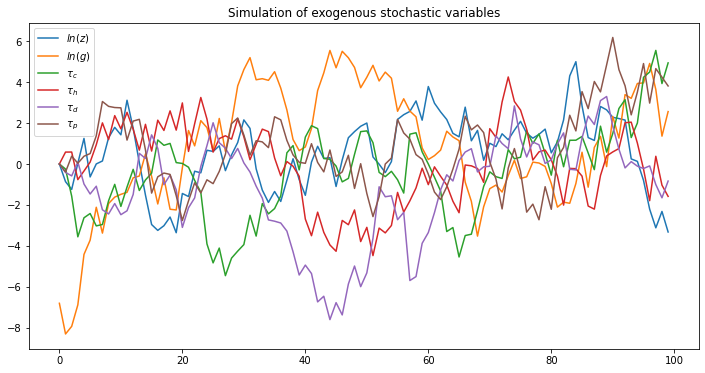

In [175]:
fig,ax = plt.subplots(figsize=(12,6))


ax.plot(ln_z, label='$ln(z)$')
ax.plot(ln_g, label='$ln(g)$')
ax.plot(τ_c, label=r'$τ_c$')
ax.plot(τ_h, label='$τ_h$')
ax.plot(τ_d, label='$τ_d$')
ax.plot(τ_p, label='$τ_p$')
ax.set_title('Simulation of exogenous stochastic variables')
ax.legend()
plt.show()

Why tax rates are not bounded by [0,1]? Because it was not assumed in the question. Why? I don't know.

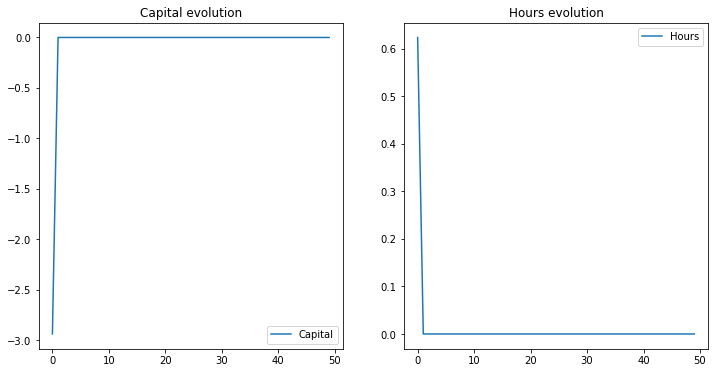

In [176]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(k[0:50], label='Capital')
ax[0].set_title('Capital evolution')
ax[0].legend()

ax[1].plot(h[0:50], label='Hours')
ax[1].set_title('Hours evolution')
ax[1].legend()

plt.show()



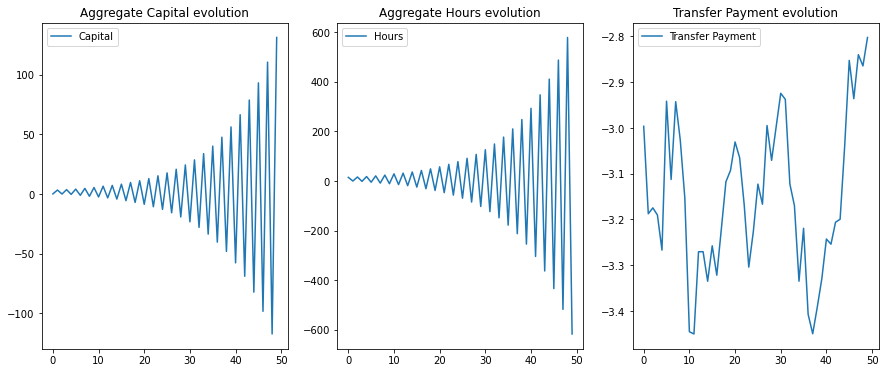

In [377]:
fig,ax = plt.subplots(1,3,figsize=(15,6))

ax[0].plot(K[0:50], label='Capital')
ax[0].set_title('Aggregate Capital evolution')
ax[0].legend()

ax[1].plot(H[0:50], label='Hours')
ax[1].set_title('Aggregate Hours evolution')
ax[1].legend()

ax[2].plot(T[0:50], label='Transfer Payment')
ax[2].set_title('Transfer Payment evolution')
ax[2].legend()

plt.show()

It is obvious that T,K, H, k and h are wrong

## Dividends, Accounting Profits and Stock Valuation Simulation

Dividends: $d_t = K_t^θ (z_t H_t)^{1-\theta} - w_t H_t - (1+τ_{dt})X_t$, where $X_t = (1+γ_n)K_{t+1} - (1-δ)K_t$

Accounting Profits: $Pr_t = d_t + k_{t+1} - k_t$

Stock Valuation: $v_t = (1+τ_{dt})K_t$

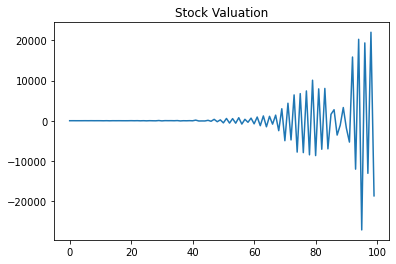

In [406]:
plt.plot((1+τ_d)*K[:100])
plt.title('Stock Valuation')
plt.show()